## Uncertainty in Near-Infrared Reddening

Holly Christenson & Kristen Larson (Western Washington University)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

In [3]:
%matplotlib inline

We'll start with the intrinsic colors and spectral types.

In [17]:
intHK= np.array([-0.1,-0.09,-0.09,-0.09,-0.09,-0.08,-0.09,-0.06,-0.07,-0.05,-0.06,-0.05,-0.05,-0.03,0,0.0025,0.005,0.0083,
            0.0117,0.015,0.02,0.025,0.0267,0.0283,0.03,0.0325,0.035,0.0367,0.0383,0.04,0.0425,0.045,0.0467,0.0483,
            0.05,0.051,0.052,0.0535,0.055,0.0575,0.06,0.06375,0.0675,0.07125,0.075,0.0825,0.09,0.0975,0.105,0.11,0.12,
            0.13,0.14217,0.1533,0.165,0.2,0.21,0.25,0.275,0.32,0.37]) 

intJH= np.array([-0.065,-0.065,-0.075,-0.095,-0.095,-0.075,-0.025,-0.045,-0.035,-0.045,-0.025,-0.025,-0.005,0.005,0,0.01,
            0.02,0.033,0.0467,0.06,0.075,0.09,0.103,0.117,0.13,0.1475,0.165,0.187,0.208,0.23,0.258,0.285,0.292,0.298,
            0.305,0.3125,0.32,0.325,0.33,0.35,0.37,0.39,0.41,0.43,0.45,0.475,0.5,0.54,0.58,0.61,0.635,0.66,0.6717,
            0.683,0.695,0.68,0.665,0.62,0.6,0.62,0.6])

SpType=np.array(['O6V','O7V','O8V','O9V','B0V','B1V','B2V','B3V','B4V','B5V','B6V','B7V','B8V','B9V',
            'A0V','A1V','A2V','A3V','A4V','A5V','A6V','A7V','A8V','A9V',
            'F0V','F1V','F2V','F3V','F4V','F5V','F6V','F7V','F8V','F9V',
            'G0V','G1V','G2V','G3V','G4V','G5V','G6V','G7V','G8V','G9V',
            'K0V','K1V','K2V','K3V','K4V','K5V','K6V','K7V','K8V','K9V',
            'M0V','M1V','M2V','M3V','M4V','M5V','M6V'])

# Use x as the bin indices
x=np.arange(intHK.size)

We start with a value of R and E(H-K) for the simulated line of sight.  For the spectral type of a background star, these choices for the line of sight imply observed colors.  

We then simulate uncertainty in observed colors and knowledge of spectral type with monte carlo sampling of normal distributions, recalcuating R at each sample.

The resulting distributions of R can be interpreted as results of repeated measurements of the same simulated line of sight.  A real observer has just one of these values in hand, of course. We will discuss how to interpret our distributions as error bars in the discussion.

**The flaw in my thinking might be coupling the uncertainty in photometry with spectral type.**

In [18]:
# Choose line-of-sight R and E(H-K)
losR=1.6
losEHK=0.4
losEJH=losR*losEHK


# Calculate the error-free photometry, all spectral types
simJH=losEJH+intJH
simHK=losEHK+intHK

# Choose spectral type by list index
meanbin = 24
stdbin = 2   # standard error, in units of number of list items
SpType[meanbin]

'F0V'

First, we simulate uncertainty in both colors by sampling independently from color distributions with standard deviations $\sigma_{JH}$ and $\sigma_{HK}$.  For each $i$ in the sample, we calculate

$$
R_i=\frac{E_{JH}}{E_{HK}}=\frac{(J-H)_i-(J-H)_0}{(H-K)_i-(H-K)_0}
$$


The standard deviation of the resulting distribution in R should be equivalent to the propagated uncertainty, 

$$
\sigma_R=\overline{R}\sqrt{\left(\frac{\sigma_{JH}}{\overline{E_{JH}}}\right)^2 + \left(\frac{\sigma_{HK}}{\overline{E_{HK}}}\right)^2}
$$

scale average actual_sigma expected_sigma
0.01 1.60097056703 0.0469664537652 0.0426181674377
0.02 1.60510165041 0.0958075196999 0.0852363348754
0.04 1.61371123958 0.193965775941 0.170472669751


[]

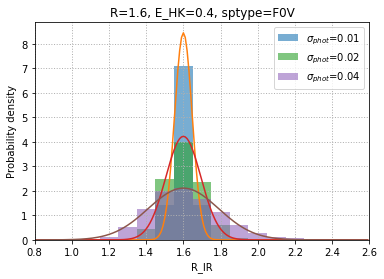

In [30]:
fig,ax=plt.subplots(1,1)
xrange=np.arange(0.8,2.6,.01)

print('scale','average','actual_sigma','expected_sigma')
for scale in [0.01,0.02,0.04]:
    sims=(np.random.normal(loc=simJH[meanbin],scale=scale,size=10000)-intJH[meanbin])/(np.random.normal(loc=simHK[meanbin],scale=scale,size=10000)-intHK[meanbin])
    expstd=1.6*np.sqrt((scale/simJH[meanbin])**2+(scale/simHK[meanbin])**2)

    print(scale,np.mean(sims),np.std(sims),expstd)
    ax.hist(sims,30,range=(0.05,3.05),normed=True,label='$\sigma_{phot}$='+str(scale),alpha=0.6)
    calcscale=losR*np.sqrt((scale/losEJH)**2+(scale/losEHK)**2)
    ax.plot(xrange,ss.norm(losR,calcscale).pdf(xrange))
    
ax.legend(loc='best')
ax.set_xlim(.8,2.6)
ax.set_title('R='+str(losR)+', E_HK='+str(losEHK)+', sptype='+SpType[meanbin])
ax.grid(linestyle='dotted',linewidth=1)
ax.set_xlabel('R_IR')
ax.set_ylabel('Probability density')
plt.plot()

Yes, for small uncertainty in color, we get simple normal distributions whose standard deviation is approximately the propagated uncertainty.

Next, we'll add some uncertainty in the spectral type.  To accomplish this, we first create a binned probability distribution for the quantized spectral type.  Because the spectral type sequence is not infinitely long, our distribution is truncated, and must be renormalized.

In [31]:


def prob_bins(x,meanbin,stdbin):
    # Create the probability distribution:
    lowedge, highedge = np.arange(len(x))-0.5,np.arange(len(x))+0.5 # put items at bin centers
    prob_bins = ss.norm.cdf(highedge, loc=meanbin, 
                            scale = stdbin)-ss.norm.cdf(lowedge, loc=meanbin, scale = stdbin)
    prob_bins = prob_bins / prob_bins.sum() # normalize the probabilities so their sum is 1

    return prob_bins



1.59682698311 0.0318968260988
1.59096918235 0.0659597601474
1.57127669253 0.131393483376


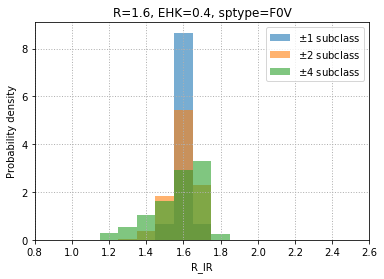

In [33]:
fig,ax=plt.subplots(1,1)

for stdbins in [1,2,4]:
    # Sample the probability distribution:
    prob = prob_bins(x,meanbin,stdbins) # customize the probability distribution
    nums = np.random.choice(x, size = 100000, p = prob) # a set of chosen bin indices

    R=(simJH[meanbin]-intJH[nums])/(simHK[meanbin]-intHK[nums])
    print(np.mean(R),np.std(R))
    ax.hist(R,30,range=(0.05,3.05),normed=True,label='$\pm$'+str(stdbins)+' subclass',alpha=0.6)

ax.set_xlabel('R_IR')
ax.set_ylabel('Probability density')
ax.set_title('R='+str(losR)+', EHK='+str(losEHK)+', sptype='+SpType[meanbin])
ax.grid(linestyle='dotted',linewidth=1)
ax.set_xlim(.8,2.6)
ax.legend(loc='best')
plt.show()

By introducing an uncertainty in the spectral classes, we have created an uncertainty in R that is comparable in size to the uncertainty introduced by photometry.  This is unsurprising, especially where intrinsic colors in adjacent spectral types differ on the same order as typical uncertainty in measured colors.

What may be surprising is the asymmetry of the distribution.  In the example shown here of an F0V type known to within 4 subclasses, the most common measurement is R = 1.7, but more measurements fall below 1.6 than above 1.6.  The root-mean-square deviation of measurements below R=1.6 is 0.14, about twice the root-mean-square deviation of measurements above R=1.6.  

In [35]:
np.sqrt(np.mean((R[R<1.6]-1.6)**2)),np.sqrt(np.mean((R[R>1.6]-1.6)**2))

(0.17905995689598908, 0.082292649244494309)

In [37]:
for stdbins in [1,2,3,4,5]:
    # Sample the probability distribution:
    prob = prob_bins(x,meanbin,stdbins) # customize the probability distribution
    nums = np.random.choice(x, size = 100000, p = prob) # a set of chosen bin indices

    R=(simJH[meanbin]-intJH[nums])/(simHK[meanbin]-intHK[nums])
    print(stdbins,np.mean(R),np.std(R),np.sqrt(np.mean((R[R<1.6]-1.6)**2)),np.sqrt(np.mean((R[R>1.6]-1.6)**2)))

1 1.59675006085 0.0318737751199 0.0461319885407 0.0231472876905
2 1.59053419221 0.0658128875989 0.088228735413 0.0463003021739
3 1.58104305216 0.100988428556 0.136389299484 0.0660040185706
4 1.57078230216 0.131250325482 0.178593327217 0.0821525519268
5 1.55808066265 0.156027384473 0.215384135378 0.0927204189841


The asymmetry gets more pronounced as the uncertainty in spectral type increases.  For example, at an uncertainty of 5 subclasses (likely reported as "a late A or early F star"), the mean is 1.5, with rms deviation of 0.1 above and 0.2 below.  

In [ ]:
fig,ax=plt.subplots(1,1)

for obsEHKs in [0.2,0.5,1.0]:

    stdbin=3
    obsEJH=obsR*obsEHKs
    
    simJH=obsEJH+intJH
    simHK=obsEHKs+intHK
    
    # Sample the probability distribution:
    prob = prob_bins(x,meanbin,stdbin)
    nums = np.random.choice(x, size = 100000, p = prob) # This is a set of bin indices

    R=(simJH[meanbin]-intJH[nums])/(simHK[meanbin]-intHK[nums])
    ax.hist(R,30,range=(0.05,3.05),normed=True,label='EHK='+str(obsEHKs),alpha=0.6)

ax.set_xlabel('R_IR')
ax.set_ylabel('Probability density')
ax.set_title('observed: SpType = '+SpType[meanbin]+' $\pm$'+str(stdbin)+' subclass')
ax.legend(loc='best')
ax.set_xlim(.8,2.6)
ax.grid(linestyle='dotted',linewidth=1)
plt.show()

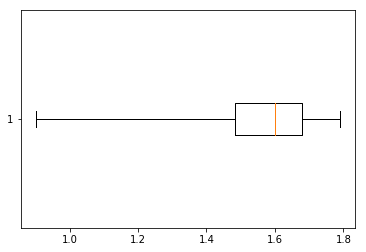

In [39]:
plt.boxplot(R,vert=False,whis=[0,100],showmeans=False)
plt.show()

In [ ]:
x=np.arange(intHK.size)

stdbin = 3   # standard error, in units of number of list items

fig,[ax0,ax1,ax2,ax3,ax4] = plt.subplots(5,1,sharex=True,sharey=True,figsize=(5,15))

for ax,meanbin in zip([ax0,ax1,ax2,ax3,ax4],[14, 24, 34, 44, 54]):

    lowedge, highedge = np.arange(len(x))-0.5, np.arange(len(x))+0.5  # put items at bin centers
    prob = ss.norm.cdf(highedge, loc=meanbin, scale = stdbin) - ss.norm.cdf(lowedge, loc=meanbin, scale = stdbin)
    prob = prob / prob.sum() # normalize the probabilities so their sum is 1

    nums = np.random.choice(x, size = 10000, p = prob)  # sample the distribution

    R=(simJH[meanbin]-intJH[nums])/(simHK[meanbin]-intHK[nums])
    
    ax.hist(R,20,range=(0,3),normed=True,color='k')

    
ax4.set_xlabel('R_IR')
ax0.set_title('observed: EHK = '+str(obsEHK))
fig.subplots_adjust(hspace=0)

plt.show()

# to do: add reddenings in greyscale
# to do: label with spectral types
# add mean and rms as whisker plot?  Then show all whisker plots